## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModelForMaskedLM
from predictor import Predictor
from tqdm.auto import tqdm
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )
    torch.set_float32_matmul_precision('high')

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU: NVIDIA RTX A6000
GPU Memory: 50.93 GB


In [2]:
# Load the dataset
df = pd.read_csv("../data/ellipsis_raw_rater_scores_anon_all_essay.csv")
print(f"Loaded {len(df)} essays")
print(f"\nColumns: {list(df.columns)}")
df.head()

Loaded 8890 essays

Columns: ['Filename', 'Text', 'Rater_1', 'Overall_1', 'Cohesion_1', 'Syntax_1', 'Vocabulary_1', 'Phraseology_1', 'Grammar_1', 'Conventions_1', 'Identifying_Info_1', 'Rater_2', 'Overall_2', 'Cohesion_2', 'Syntax_2', 'Vocabulary_2', 'Phraseology_2', 'Grammar_2', 'Conventions_2', 'Identifying_Info_2']


,Filename,Text,Rater_1,Overall_1,Cohesion_1,Syntax_1,Vocabulary_1,Phraseology_1,Grammar_1,Conventions_1,Identifying_Info_1,Rater_2,Overall_2,Cohesion_2,Syntax_2,Vocabulary_2,Phraseology_2,Grammar_2,Conventions_2,Identifying_Info_2
0,2021000071.txt,"To the Principal,\r\n\r\nI think that policy 1...",rater_1,3,3,4,4,4,5,3,0,rater_2,3,4,3,3,3,3,3,0
1,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",rater_1,3,3,2,3,3,3,2,0,rater_2,3,4,3,4,3,4,3,0
2,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",rater_1,3,2,3,2,2,3,3,0,rater_2,3,3,3,4,3,3,4,0
3,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,rater_1,3,2,3,3,3,3,3,0,rater_2,3,3,3,3,3,4,3,0
4,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,rater_1,3,2,3,3,3,3,3,0,rater_2,3,2,2,3,3,3,2,0


## 2. Load Models

In [3]:
# Load spaCy for tokenization
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_lg")
print("✓ spaCy loaded")

Loading spaCy model...
✓ spaCy loaded
✓ spaCy loaded


In [4]:
# Load ModernBERT model and tokenizer
model_name = "answerdotai/ModernBERT-base"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

print("✓ ModernBERT loaded")

Loading answerdotai/ModernBERT-base...
✓ ModernBERT loaded
✓ ModernBERT loaded


In [5]:
# Initialize predictor
device = "cuda" if torch.cuda.is_available() else "cpu"
window_size = 64
batch_size = 32

predictor = Predictor(
    tokenizer=tokenizer,
    model=model,
    model_type="masked",
    batch_size=batch_size,
    device=device,
)

print("Predictor initialized:")
print("  Model type: masked")
print(f"  Window size: {window_size}")
print(f"  Batch size: {batch_size}")
print(f"  Device: {device}")

Predictor initialized:
  Model type: masked
  Window size: 64
  Batch size: 32
  Device: cuda


In [ ]:
# Reload the predictor module with all fixes and reinitialize
import importlib
import predictor as predictor_module
importlib.reload(predictor_module)
from predictor import Predictor

# Reinitialize the global predictor with fixed code
predictor = Predictor(
    tokenizer=tokenizer,
    model=model,
    model_type="masked",
    batch_size=batch_size,
    device=device,
)

print("✓ Predictor reloaded with fixes")
print(f"  Device: {device}")
print(f"  Window size: {window_size}")
print(f"  Batch size: {batch_size}")

Testing previously problematic essays with all fixes:

Essay 1154: ✓ Success (mean_loss=1.3809, tokens=343)
Essay 1762: ✓ Success (mean_loss=8.1437, tokens=1)
Essay 1154: ✓ Success (mean_loss=1.3809, tokens=343)
Essay 1762: ✓ Success (mean_loss=8.1437, tokens=1)
Essay 5391: ✓ Success (mean_loss=2.1105, tokens=670)
Essay 6820: ✓ Success (mean_loss=6.6108, tokens=19)
Essay 5391: ✓ Success (mean_loss=2.1105, tokens=670)
Essay 6820: ✓ Success (mean_loss=6.6108, tokens=19)
Essay 7400: ✓ Success (mean_loss=1.6566, tokens=696)
Essay 8277: ✓ Success (mean_loss=4.3851, tokens=1)
Essay 7400: ✓ Success (mean_loss=1.6566, tokens=696)
Essay 8277: ✓ Success (mean_loss=4.3851, tokens=1)


## 3. Process Essays and Calculate Predictability

In [9]:
# Storage for results
results = {"mean_loss": [], "mean_prob": [], "mean_entropy": []}

# Process each essay
print(f"Processing {len(df)} essays...\n")

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Calculating predictability"):
    text = row["Text"]

    # Skip if text is missing or empty
    if pd.isna(text) or text.strip() == "":
        results["mean_loss"].append(None)
        results["mean_prob"].append(None)
        results["mean_entropy"].append(None)
        continue

    try:
        # Process with spaCy
        doc = nlp(text)

        # Calculate predictability
        doc_pred = predictor(doc, window_size=window_size)

        # Store aggregate metrics
        results["mean_loss"].append(doc_pred.mean_loss)
        results["mean_prob"].append(
            sum(t.mean_prob for t in doc_pred) / len(doc_pred)
        )
        results["mean_entropy"].append(doc_pred.mean_entropy)

    except Exception as e:
        print(f"\nError processing essay {idx} (Filename: {row['Filename']}): {e}")
        results["mean_loss"].append(None)
        results["mean_prob"].append(None)
        results["mean_entropy"].append(None)

print("\n✓ Processing complete!")

Processing 8890 essays...



Calculating predictability:  13%|█▎        | 1155/8890 [16:08<1:16:56,  1.68it/s]


Error processing essay 1154 (Filename: AAAUUP138190002363252106_OR.txt): index 64 is out of bounds for dimension 1 with size 64


Calculating predictability:  20%|█▉        | 1762/8890 [24:43<1:24:18,  1.41it/s]


Error processing essay 1762 (Filename: AAAXMP138190000227192108_OR.txt): index 0 is out of bounds for axis 0 with size 0


Calculating predictability:  61%|██████    | 5392/8890 [1:12:56<57:15,  1.02it/s]  


Error processing essay 5391 (Filename: AAAUUP138190002108142106_OR.txt): index 64 is out of bounds for dimension 1 with size 64


Calculating predictability:  77%|███████▋  | 6820/8890 [1:30:33<17:28,  1.97it/s]  


Error processing essay 6820 (Filename: 2241001312.txt): index 64 is out of bounds for axis 0 with size 64


Calculating predictability:  83%|████████▎ | 7401/8890 [1:38:00<22:04,  1.12it/s]


Error processing essay 7400 (Filename: AAAUUP138190000526312106_OR.txt): index 64 is out of bounds for dimension 1 with size 64


Calculating predictability:  93%|█████████▎| 8277/8890 [1:49:40<06:00,  1.70it/s]


Error processing essay 8277 (Filename: AAAUUP138190003347492852_OR.txt): index 0 is out of bounds for axis 0 with size 0


Calculating predictability: 100%|██████████| 8890/8890 [1:58:23<00:00,  1.25it/s]


✓ Processing complete!


## 4. Add Results to DataFrame and Save

In [12]:
# Add new columns to dataframe
df["mean_loss"] = results["mean_loss"]
df["mean_prob"] = results["mean_prob"]
df["mean_entropy"] = results["mean_entropy"]

# Display summary statistics
print("Summary statistics for predictability metrics:\n")
print(df[["mean_loss", "mean_prob", "mean_entropy"]].describe())

# Show first few rows
print("\nFirst few rows with new metrics:")
df[["Filename", "mean_loss", "mean_prob", "mean_entropy"]].head(10)

Summary statistics for predictability metrics:

         mean_loss    mean_prob  mean_entropy
count  8884.000000  8884.000000   8884.000000
mean      2.014252     0.494417      1.697876
std       0.774909     0.102046      0.526916
min       0.656923     0.001115      0.677336
25%       1.509272     0.438065      1.346362
50%       1.844264     0.509351      1.583696
75%       2.318111     0.566199      1.914125
max      13.503202     0.784863      5.668056

First few rows with new metrics:


,Filename,mean_loss,mean_prob,mean_entropy
0,2021000071.txt,1.409499,0.596820,1.274440
1,2021000501.txt,1.859207,0.507485,1.452349
2,2021000535.txt,1.566912,0.552855,1.399027
3,2021000667.txt,1.837095,0.444501,1.751493
4,2021000683.txt,1.384696,0.573470,1.363560
5,2021000705.txt,2.139316,0.480182,1.749828
6,2021000748.txt,1.591411,0.570633,1.272403
7,2021000756.txt,1.827986,0.502922,1.593988
8,2021001001.txt,1.683772,0.492410,1.502543
9,2021001035.txt,1.646023,0.496363,1.555399


In [11]:
# Save to file
output_path = "../data/ellipsis_raw_rater_scores_anon_all_essay_w_predictability.csv"
df.to_csv(output_path, index=False)
print(f"✓ Results saved to: {output_path}")
print(f"  Total essays: {len(df)}")
print(f"  Columns: {len(df.columns)}")

✓ Results saved to: ../data/ellipsis_raw_rater_scores_anon_all_essay_w_predictability.csv
  Total essays: 8890
  Columns: 23


## 5. Quick Validation and Visualization

In [13]:
# Check for any missing values
missing_counts = df[["mean_loss", "mean_prob", "mean_entropy"]].isna().sum()
print("Missing values per column:")
print(missing_counts)

if missing_counts.sum() > 0:
    print("\nEssays with missing predictability scores:")
    print(df[df["mean_loss"].isna()][["Filename", "Text"]].head())

Missing values per column:
mean_loss       6
mean_prob       6
mean_entropy    6
dtype: int64

Essays with missing predictability scores:
                             Filename  \
1154  AAAUUP138190002363252106_OR.txt   
1762  AAAXMP138190000227192108_OR.txt   
5391  AAAUUP138190002108142106_OR.txt   
6820                   2241001312.txt   
7400  AAAUUP138190000526312106_OR.txt   

                                                   Text  
1154  I agree with what Thomas Jefferson wrote, "Det...  
1762                                                  ?  
5391  Many people had accomplish something in there ...  
6820  yourprincipalisdecidingwethertorequirallstuden...  
7400  Imagine if you want to be a soccer player. If ...  


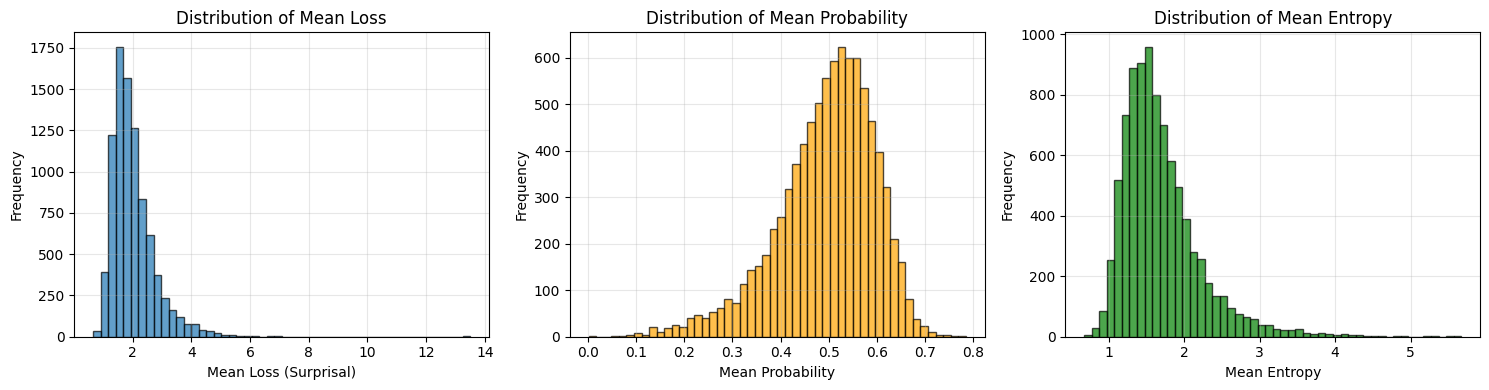

In [16]:
# Optional: Create simple visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Mean Loss distribution
axes[0].hist(df["mean_loss"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Mean Loss (Surprisal)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Mean Loss")
axes[0].grid(alpha=0.3)

# Mean Probability distribution
axes[1].hist(
    df["mean_prob"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="orange"
)
axes[1].set_xlabel("Mean Probability")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Mean Probability")
axes[1].grid(alpha=0.3)

# Mean Entropy distribution
axes[2].hist(
    df["mean_entropy"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="green"
)
axes[2].set_xlabel("Mean Entropy")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Mean Entropy")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()